In [5]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft
import tqdm #.notebook import tqdm

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

Created WidebandSignal with 1.0 MHz total bandwidth and 50000 samples per step.


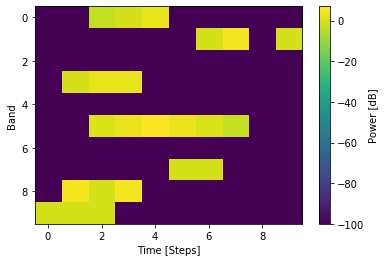

Signal power: 5.78 dB
Noise power:  0.00 dB
SNR:          5.78 dB
Num samples:  500000 


In [6]:
# general settings for signal and noise
length = .5  # in s
noise_power = 0.0  # in dB
num_bands = 10

# create 'WidebandSignal' object
wbs = ss.WidebandSignal(t_sec=length, num_bands=num_bands, num_steps=10)

# signal power matrix (dimensions: num_bands x num_steps)
mat = np.array([[-100, -100,   -3,    0,    3, -100, -100, -100, -100, -100],
                [-100, -100, -100, -100, -100, -100,    0,    5, -100,    0],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100,    0,    3,    3, -100, -100, -100, -100, -100, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100, -100,    1,    4,    7,    4,    1,   -3, -100, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100, -100, -100, -100, -100,    0,    0, -100, -100, -100],
                [-100,    5,    0,    5, -100, -100, -100, -100, -100, -100],
                [   0,    0,    0, -100, -100, -100, -100, -100, -100, -100]])

# plot the matrix
wbs.plot(mat)

# generate actual signal from matrix
sig, sample_freq = wbs.signal(mat)

# create the noise
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.signal(power=noise_power, dB=True)

# ensure noise and signal have same length (and create global variable 'num_samples')
assert wbs.num_samples == wgn.num_samples
num_samples = wbs.num_samples

# create actual signal ('both') comprising of signal and additive white Gaussian noise (AWGN)
both = sig + noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d ' % (num_samples))

# ensure that Parseval's theorem holds
ss.util.check_parseval(both, length, sample_freq)

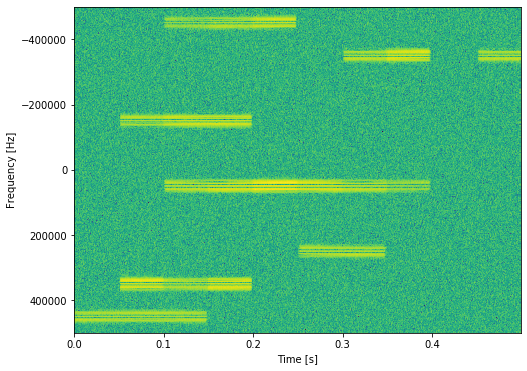

In [7]:
# use the 2d plot function to plot the spectogram
ss.spectrum_plot_2d(sig=both,
                    f_sample=sample_freq,
                    window='flattop',
                    nfft=1024)

100%|██████████| 488/488 [00:01<00:00, 457.57it/s]


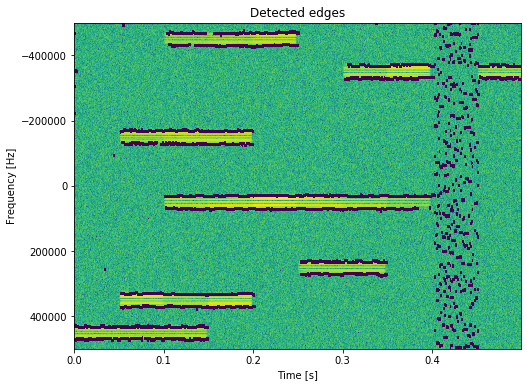

100%|██████████| 488/488 [00:05<00:00, 87.92it/s] 


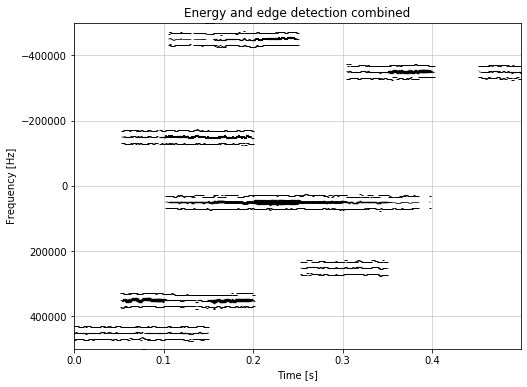

Entries of 90th fft at time 0.092s: 
--- Entry number 0 ---
Band center freq: -151367.19
Energy in band:   1026.84
Band upper freq:  -169921.88
Band lower freq:  -132812.50
Band width:       37109.38
--- Entry number 1 ---
Band center freq: 349609.38
Energy in band:   3351.95
Band upper freq:  329101.56
Band lower freq:  371093.75
Band width:       41992.19
--- Entry number 2 ---
Band center freq: 449218.75
Energy in band:   1046.40
Band upper freq:  431640.62
Band lower freq:  467773.44
Band width:       36132.81


In [8]:
# use edge detection in spectrum in oder to detect spectrum areas of interest
fft_len = 1024

# create a Short Time Fourier Transform object
sft = ss.Stft(n=fft_len, window='flattop')

# use the stft to transform the signal into the frequency domain
f, t, x = sft.spectogram(both, sample_freq, normalized=False, dB=False)

# Variable Band Energy Detector
vbed = ss.VariableBandEnergyDetector(
    fft_len=fft_len,
    freqs=f,
    noise_power=noise_power,
    pfa=0.01,  # !!! has no real meaning here anymore 
    smooth=5.,  # number of ffts used for smoothing
    scale=4,  # number of multi-scale wavelet products
    min_height=0.1,  # min height required
    energy_compensation=0.2)  # compensate for leaking energy

# empty overlay picture of edges in spectrum
res = np.empty(shape=(len(f), len(t)))
res[:] = np.nan

# empty detection results
det = np.array([])

# go over spectrum ('in time') and detect
for i, _ in enumerate(tqdm.tqdm(t)):

    # do actual detection
    ps, peak, peakf, dics = vbed.detect(x[:, i])

    # store edges in res
    res = ss.util_wide.store_pic(pic=res,
                                 x=i,
                                 y=peak,
                                 n=3,
                                 val=1.,
                                 minimum=0,
                                 maximum=len(f))

    # store detection results in det
    det = np.append(det, dics)

# plot spectrum and edges in one picture
plt.figure(figsize=(8, 6))
plt.title('Detected edges')
plt.pcolormesh(t,
               f,
               ss.util.dB_power(x),
               cmap='viridis',
               vmin=np.min(ss.util.dB_power(x)),
               vmax=np.max(ss.util.dB_power(x)))
plt.pcolormesh(t, f, res, cmap='viridis')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.gca().set_xlim([np.min(t), np.max(t)])
plt.gca().set_ylim([np.min(f), np.max(f)])
plt.gca().invert_yaxis()
plt.show()

# plot detection results
plt.figure(figsize=(8, 6))
plt.title('Energy and edge detection combined')
for i, dic in enumerate(tqdm.tqdm(det)):
    for j, d in enumerate(dic.items()):
        plt.plot(t[i], f[int(d[1][1])], 'k_', markersize=2)
        plt.plot(t[i], f[int(d[0])], 'k_', markersize=2, markeredgewidth=d[1][0] / 1000)
        plt.plot(t[i], f[int(d[1][2])], 'k_', markersize=2)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.grid(linewidth=0.5)
plt.gca().set_xlim([np.min(t), np.max(t)])
plt.gca().set_ylim([np.min(f), np.max(f)])
plt.gca().invert_yaxis()
plt.show()

# print some band stats
idx = 90
print('Entries of %dth fft at time %.3fs: ' % (idx, idx * (t[1] - t[0])))
for j, d in enumerate(det[idx].items()):
    print('--- Entry number %d ---' % (j))
    print('Band center freq: %.2f' % (f[d[0]]))
    print('Energy in band:   %.2f' % (d[1][0]))
    print('Band upper freq:  %.2f' % (f[d[1][1]]))
    print('Band lower freq:  %.2f' % (f[d[1][2]]))
    print('Band width:       %.2f' % (d[1][3] * (f[1] - f[0])))